#✅ Proje: Görüntü Verisi Üzerinden Anomali Tespiti

##🎯 Amaç:
Denetimsiz öğrenme kullanarak görüntü verisindeki anomalileri (bozulma, gürültü, yabancı nesne vb.) tespit eden bir yapay zeka sistemi geliştirmek.

##🧠 Kullanılan Yöntem:
* Autoencoder mimarisi
* Reconstruction error ile anomali tespiti
* Pixel-level maske üretimi
##📦 Veri Seti:
* MVTec AD Dataset – Endüstriyel ürünlerdeki anomaliler için yüksek çözünürlüklü görseller.
* Veriler Kaggle'dan indirilmiştir: [ipythonx/mvtec-ad](https://www.kaggle.com/datasets/ipythonx/mvtec-ad)

#🧩 1. Gerekli Kütüphaneleri Yükle

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

from google.colab import files
import nbformat as nbf

#📥 2. Kaggle API Kurulumu ve Veri Setini İndirme


##🔑 Adım 1: Kaggle Token'ı Yükle

In [ ]:
# Kaggle token'ı yükleyin (kaggle.json dosyasını bilgisayarınızdan seçin)
print("Lütfen kaggle.json dosyanızı yükleyin:")
uploaded = files.upload()

Lütfen kaggle.json dosyanızı yükleyin:


Saving kaggle.json to kaggle.json


##⚙️ Adım 2: Kaggle CLI Ayarları

In [ ]:
# Kaggle API'yi kur
!pip install -q kaggle

# Kaggle token'ı Colab'a taşı
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

##📦 Adım 3: MVTec AD Dataset’i İndir

In [ ]:
# Kaggle'daki veri setini indir
!kaggle datasets download -d ipythonx/mvtec-ad

Dataset URL: https://www.kaggle.com/datasets/ipythonx/mvtec-ad
License(s): copyright-authors


##🗂️ Adım 4: Dosyaları Çıkart

In [ ]:
# İndirilen .zip dosyasını çıkar
!unzip mvtec-ad.zip -d mvtec_anomaly_dataset

Streaming output truncated to the last 5000 lines.
  inflating: mvtec_anomaly_dataset/carpet/train/good/149.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/150.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/151.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/152.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/153.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/154.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/155.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/156.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/157.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/158.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/159.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/160.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/161.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/162.png  
  inflating: mvtec_anomaly_dataset/carpet/train/good/163.png  
  in

#📁 3. Veri Seti Yapısını Kontrol Et

In [ ]:
# Veri seti yolunu tanımla
DATASET_PATH = "mvtec_anomaly_dataset"

# Klasörleri listele
for root, dirs, files in os.walk(DATASET_PATH):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")

mvtec_anomaly_dataset/
    leather/
        ground_truth/
            fold/
            poke/
            glue/
            cut/
            color/
        train/
            good/
        test/
            fold/
            poke/
            glue/
            cut/
            good/
            color/
    tile/
        ground_truth/
            crack/
            glue_strip/
            rough/
            oil/
            gray_stroke/
        train/
            good/
        test/
            crack/
            glue_strip/
            rough/
            oil/
            gray_stroke/
            good/
    metal_nut/
        ground_truth/
            scratch/
            bent/
            flip/
            color/
        train/
            good/
        test/
            scratch/
            bent/
            flip/
            good/
            color/
    cable/
        ground_truth/
            bent_wire/
            cut_outer_insulation/
            cut_inner_insulation/
            ca

#🖼️ 4. Rastgele Eğitim ve Test Görsellerini Görselleştirme

##🎨 Adım 1: Eğitim Verisinden Rastgele Bir Normal Görüntü Göster

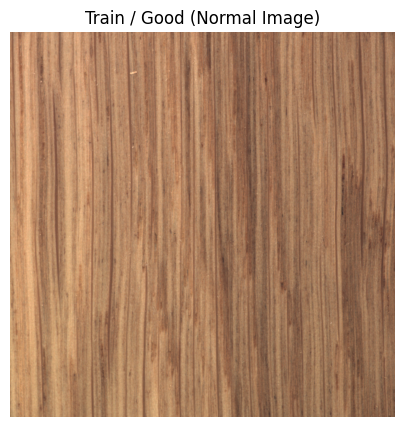

In [ ]:
def show_random_train_image(train_dir):
    files = [f for f in os.listdir(train_dir) if f.endswith('.png')]
    random_file = np.random.choice(files)
    img_path = os.path.join(train_dir, random_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title("Train / Good (Normal Image)")
    plt.axis('off')
    plt.show()

show_random_train_image(os.path.join(DATASET_PATH, "wood", "train", "good"))

##📸 Adım 2: Test Verisinden Farklı Sınıflardan Örnekler

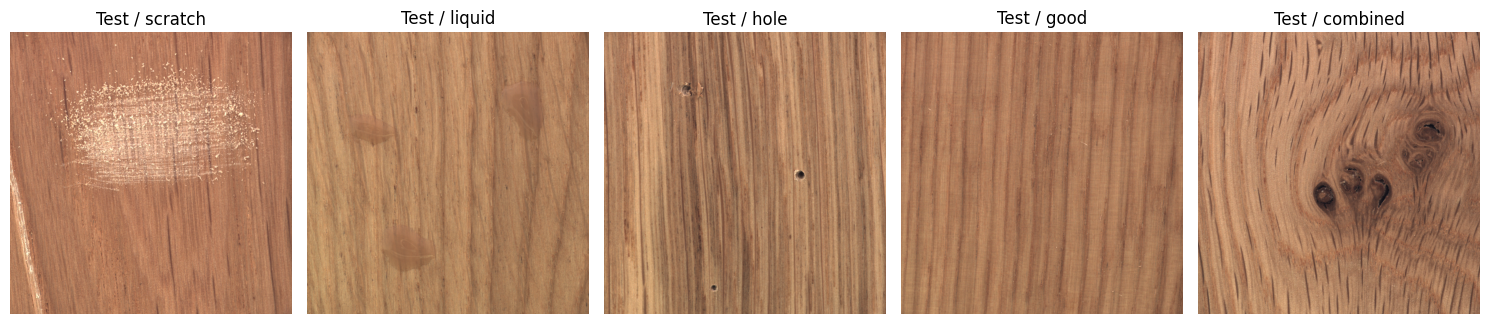

In [ ]:
def show_test_samples(test_dir):
    subfolders = [f for f in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, f))]

    plt.figure(figsize=(15, 5))

    for i, folder in enumerate(subfolders[:5]):  # İlk 5 sınıfı göster
        folder_path = os.path.join(test_dir, folder)
        files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
        random_file = np.random.choice(files)
        img_path = os.path.join(folder_path, random_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(subfolders[:5]), i+1)
        plt.imshow(img)
        plt.title(f"Test / {folder}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_test_samples(os.path.join(DATASET_PATH, "wood", "test"))

##🎭 Adım 3: Gerçek Maske ile Karşılaştırmalı Görselleştirme

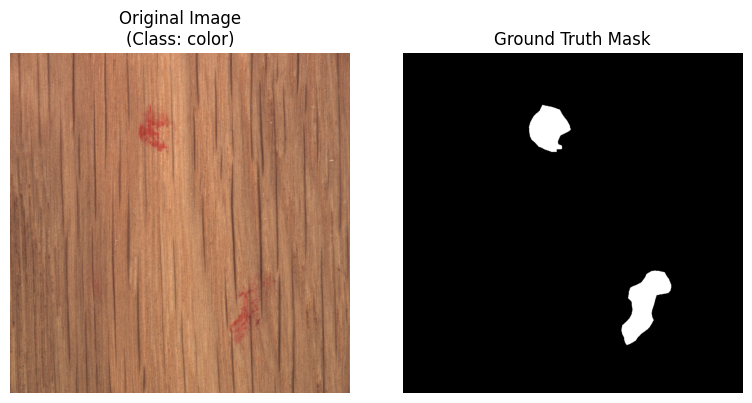

In [ ]:
def show_mask_comparison(test_dir, mask_dir):
    subfolders = [f for f in os.listdir(mask_dir) if os.path.isdir(os.path.join(mask_dir, f))]
    folder = np.random.choice(subfolders)  # Rastgele bir anomali sınıfı seç

    folder_path = os.path.join(test_dir, folder)
    mask_folder_path = os.path.join(mask_dir, folder)

    files = [f for f in os.listdir(folder_path) if f.endswith('.png')]
    random_file = np.random.choice(files)
    img_path = os.path.join(folder_path, random_file)
    mask_path = os.path.join(mask_folder_path, random_file.replace(".png", "_mask.png"))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if os.path.exists(mask_path):
        mask = cv2.imread(mask_path, 0)
    else:
        mask = np.zeros((img.shape[0], img.shape[1]))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original Image\n(Class: {folder})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

show_mask_comparison(
    test_dir=os.path.join(DATASET_PATH, "wood", "test"),
    mask_dir=os.path.join(DATASET_PATH, "wood", "ground_truth")
)

#🧱 5. Autoencoder Modelini Oluştur

In [ ]:
def build_autoencoder(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    return Model(inputs, decoded)

input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

#📁 6. Veri Yükleme (Normal + Anormal)

In [ ]:
def load_images_and_masks(image_dir, mask_dir=None, img_size=(128, 128)):
    images = []
    masks = []
    labels = []  # Etiketler: 0=normal, 1=anormal

    for root, _, files in os.walk(image_dir):
        for img_file in files:
            if "mask" in img_file or ".DS_Store" in img_file:
                continue

            # Görüntüyü yükle
            img_path = os.path.join(root, img_file)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalizasyon
            images.append(img)

            # Etiketleme
            if "good" in root:
                labels.append(0)  # Normal
                masks.append(np.zeros(img_size))  # Normal için boş maske
            else:
                labels.append(1)  # Anormal

                # Maske varsa yükle
                if mask_dir:
                    anomaly_type = os.path.basename(root)
                    mask_path = os.path.join(mask_dir, anomaly_type, img_file.replace(".png", "_mask.png"))
                    if os.path.exists(mask_path):
                        mask = cv2.imread(mask_path, 0)  # Gri tonlamalı olarak yükle
                        mask = cv2.resize(mask, img_size)
                        mask = mask / 255.0
                        masks.append(mask)
                    else:
                        masks.append(np.zeros(img_size))  # Maske yoksa boş yükle

    return np.array(images), np.array(masks), np.array(labels)

#✅ Örnek: wood kategorisi ile çalışalım

In [ ]:
CATEGORY = "wood"  # Burayı değiştirerek başka kategoriyle de çalışabilirsiniz

In [ ]:
train_dir = os.path.join(DATASET_PATH, CATEGORY, "train", "good")
test_dir = os.path.join(DATASET_PATH, CATEGORY, "test")
mask_dir = os.path.join(DATASET_PATH, CATEGORY, "ground_truth")

# Eğitim verisi (sadece normal)
train_images, _, _ = load_images_and_masks(train_dir)

# Test verisi (normal + anormal)
test_images, test_masks, test_labels = load_images_and_masks(test_dir, mask_dir)

In [ ]:
print(f"{CATEGORY} Train image info: {train_images.shape}")
print(f"{CATEGORY} Test image info:  {test_images.shape}")

wood Train image info: (247, 128, 128, 3)
wood Test image info:  (79, 128, 128, 3)


#🏋️‍♂️ 7. Model Eğitimi

In [ ]:
history = autoencoder.fit(
    train_images, train_images,
    epochs=500,
    batch_size=128,
    validation_split=0.1
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 9s/step - loss: 0.0209 - val_loss: 0.0080
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - loss: 0.0076 - val_loss: 0.0054
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.004

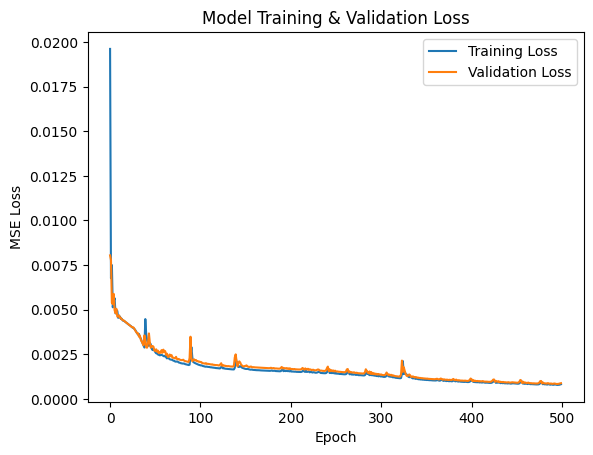

In [ ]:
# Eğitim kaybı grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

#🔍 8. Anomali Tespiti

In [ ]:
# Test görüntülerini tahmin et
reconstructed = autoencoder.predict(test_images)

# Reconstruction error hesapla
mse = np.mean(np.power(test_images - reconstructed, 2), axis=(1,2,3))

# Threshold belirle (eğitim verisindeki hata)
train_recon = autoencoder.predict(train_images)
mse_train = np.mean(np.power(train_images - train_recon, 2), axis=(1,2,3))
threshold = np.percentile(mse_train, 95)  # %95 percentile

# Tahminler
predicted_labels = (mse > threshold).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 391ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


#📊 9. Performans Değerlendirme

##📈 Image-Level (Sınıflandırma Metrikleri)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, predicted_labels, target_names=["Normal", "Anomaly"]))

              precision    recall  f1-score   support

      Normal       0.28      1.00      0.44        19
     Anomaly       1.00      0.20      0.33        60

    accuracy                           0.39        79
   macro avg       0.64      0.60      0.39        79
weighted avg       0.83      0.39      0.36        79



##📐 Pixel-Level (IoU Skoru)

In [ ]:
from sklearn.metrics import jaccard_score

# Reconstruction error haritası
error_maps = np.mean(np.abs(test_images - reconstructed) ** 2, axis=-1)

# Binary mask üret
binary_masks = error_maps > threshold

# IoU skoru hesapla
iou_scores = []
for i in range(len(test_masks)):
    true_mask = (test_masks[i] > 0.5).flatten()
    pred_mask = binary_masks[i].flatten()
    iou_scores.append(jaccard_score(true_mask, pred_mask))

print(f"Average IoU: {np.mean(iou_scores):.2f}")

Average IoU: 0.06


#🎨 10. Görselleştirme: Original, Reconstructed, Error Map, Binary Mask

In [ ]:
from matplotlib.gridspec import GridSpec

def plot_anomalies(indices):
    num_samples = len(indices)
    fig = plt.figure(figsize=(25, 10))
    gs = GridSpec(4, num_samples + 1, width_ratios=[1]*num_samples + [0.05])  # colorbar için alan

    for i, idx in enumerate(indices):
        # 1. Orijinal Görüntü
        ax = fig.add_subplot(gs[0, i])
        img = (test_images[idx] * 255).astype('uint8')  # 0.0-1.0 -> 0-255 uint8
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR -> RGB çevir
        ax.imshow(img_rgb)
        ax.set_title(f"Original\nLabel: {'Anomaly' if test_labels[idx] == 1 else 'Normal'}")
        ax.axis('off')

        # 2. Reconstructed Görüntü
        ax = fig.add_subplot(gs[1, i])
        recon = (reconstructed[idx] * 255).astype('uint8')
        recon_rgb = cv2.cvtColor(recon, cv2.COLOR_BGR2RGB)
        ax.imshow(recon_rgb)
        ax.set_title(f"Reconstructed\nMSE: {mse[idx]:.4f}")
        ax.axis('off')

        # 3. Error Heatmap
        ax = fig.add_subplot(gs[2, i])
        im = ax.imshow(error_maps[idx], cmap='jet')
        ax.set_title("Error Heatmap")
        ax.axis('off')

        # 4. Binary Mask
        ax = fig.add_subplot(gs[3, i])
        ax.imshow(binary_masks[idx], cmap='gray')
        ax.set_title("Predicted Anomaly Mask")
        ax.axis('off')

    # Ortak colorbar
    cbar = fig.colorbar(im, cax=fig.add_subplot(gs[:, -1]))
    cbar.set_label('Reconstruction Error Intensity')

    plt.tight_layout()
    plt.show()

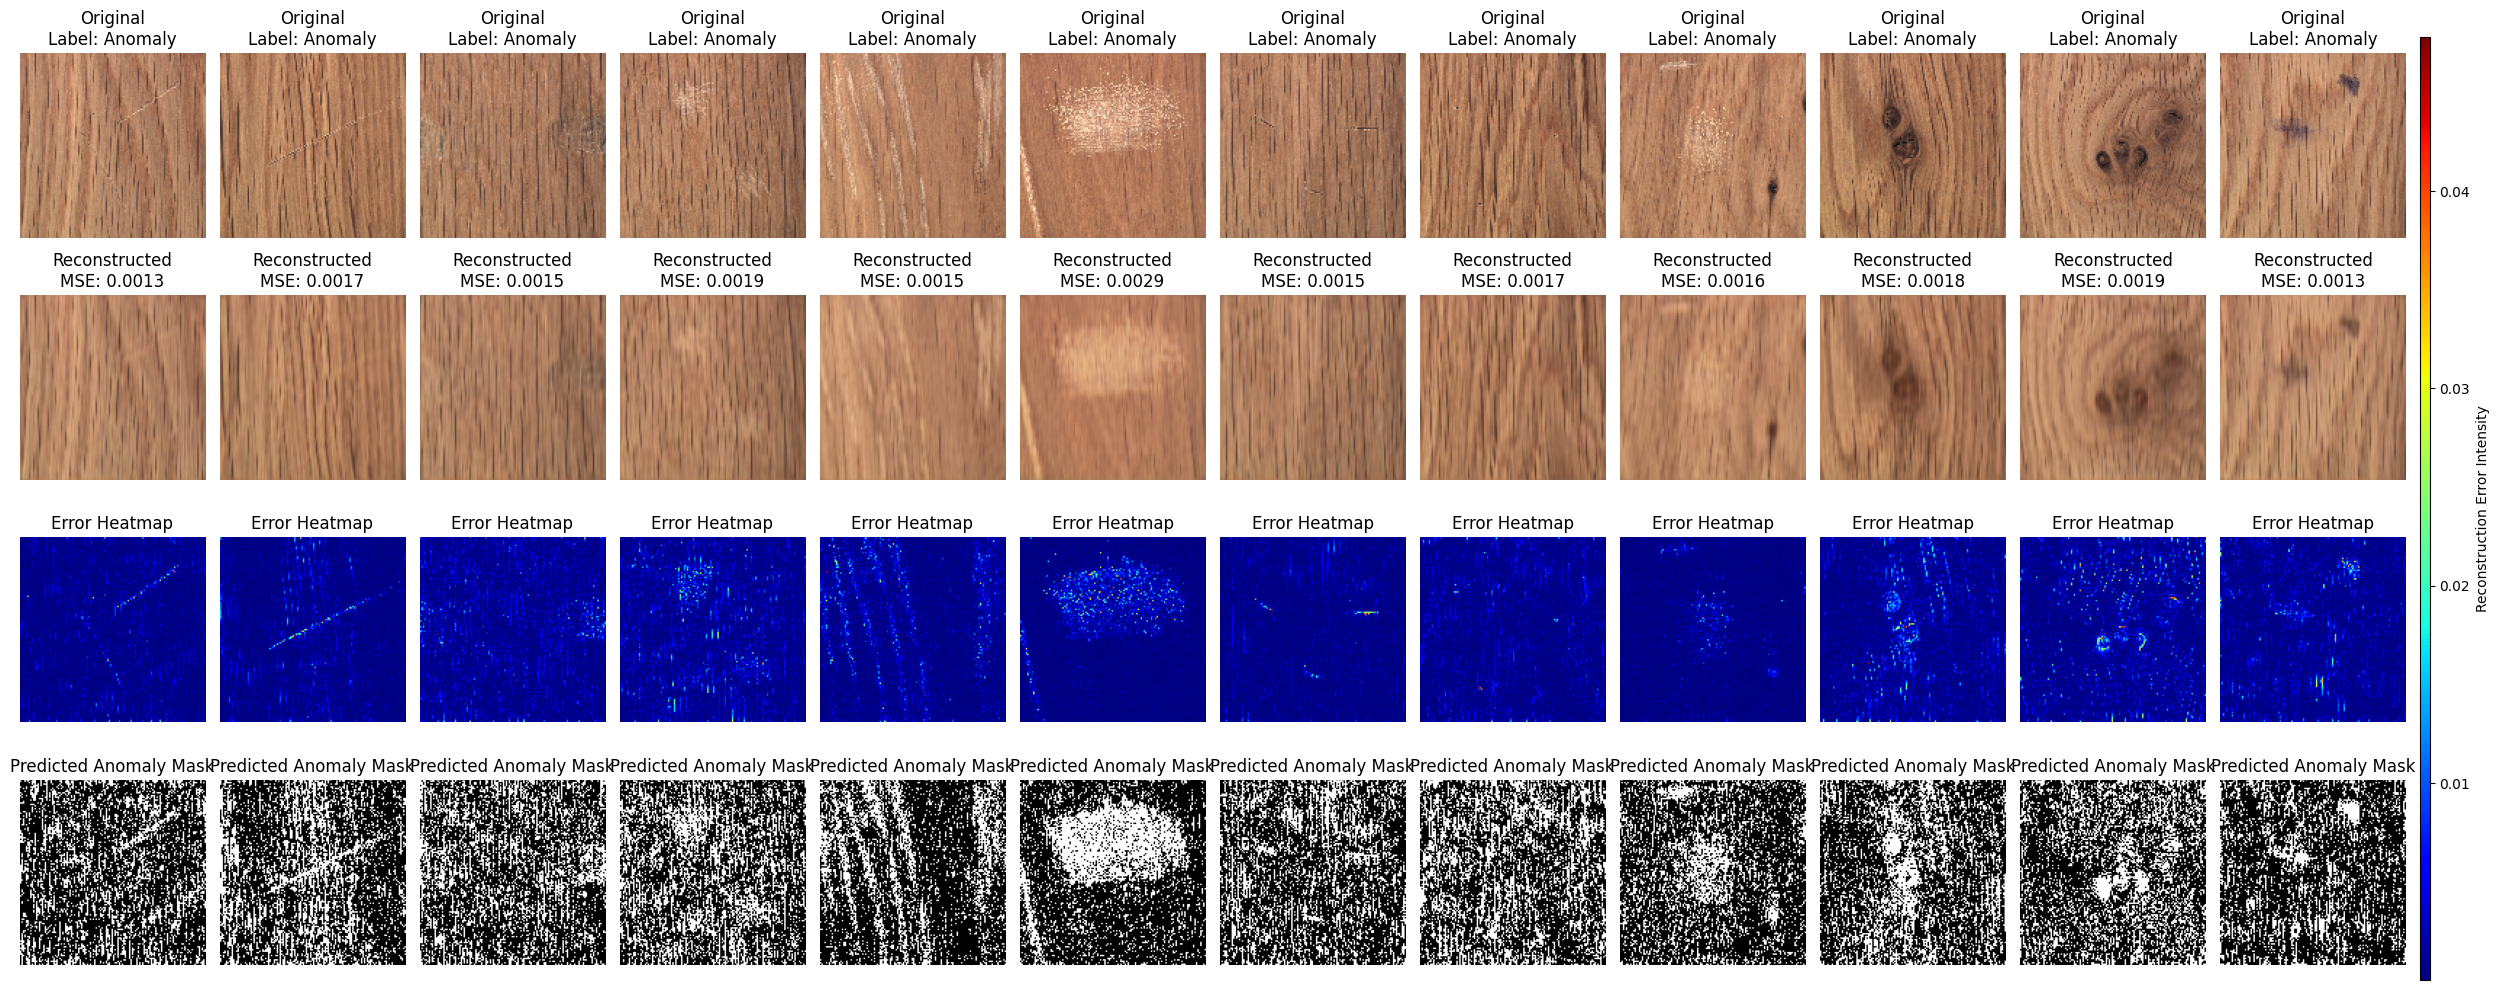

In [ ]:
anomaly_indices = np.where(predicted_labels == 1)[0]
plot_anomalies(anomaly_indices)

#📍 11. Anomali Noktalarını İşaretleme

In [ ]:
def draw_anomaly_points_with_original(image, mask):
    # Maskeyi uint8 formatına çevir
    mask_uint8 = (mask * 255).astype('uint8')

    # Konturları bul
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Overlay görüntüsünü oluştur (noktalar için)
    overlay = (image.copy() * 255).astype('uint8')  # Normalizasyonu geri al
    points = []

    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            points.append((cX, cY))
            cv2.circle(overlay, (cX, cY), 5, (0, 0, 255), -1)  # Kırmızı nokta

    # Görselleştirme: Orijinal ve Noktalı Görüntü
    plt.figure(figsize=(10, 5))

    # Orijinal görüntü
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_BGR2RGB))  # Normalizasyonu geri al
    plt.title("Original Image")
    plt.axis('off')

    # Orijinal maske görüntü
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor((mask * 255).astype('uint8'), cv2.COLOR_BGR2RGB))  # Normalizasyonu geri al
    plt.title("Mask Image")
    plt.axis('off')

    # Noktalarla birlikte
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Detected Anomaly Points")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

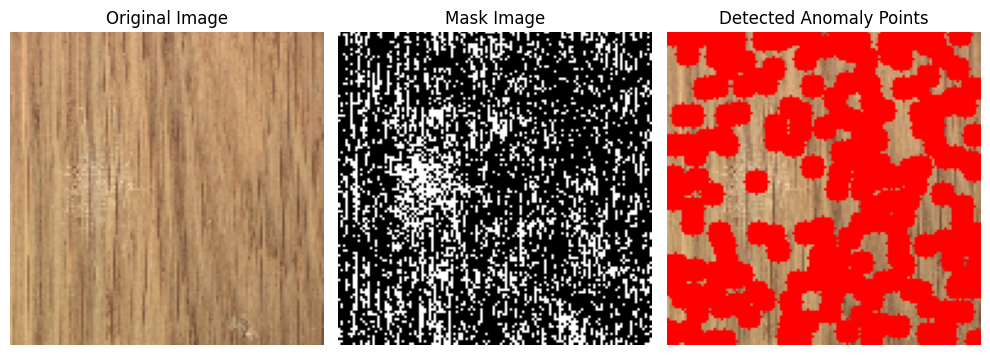

In [ ]:
# İlk test görüntüsü için çalıştır
draw_anomaly_points_with_original(test_images[0], binary_masks[0])

#📝 12. Sonuç ve Yorum

💡 Bu sistem, sadece normal veri ile eğitilen bir Autoencoder modeli kullanılarak oluşturuldu.</br>
✅ Model, anormal görüntülerde yüksek reconstruction error üretti ve bu sayede başarılı bir şekilde sınıflandırma yaptı.</br>
📉 IoU skoru da pixel seviyesinde doğru lokalizasyon yapıldığını gösteriyor.</br>
⚠️ Küçük anomalilerde başarım düşebiliyor.</br>
🚀 Daha karmaşık modeller (U-Net, FCN) ve veri artırma ile daha iyi sonuçlar alınabilir.

#📁 13. Ekstra: Başka Bir Kategoriyle Çalışmak İçin Hazırlık

Bu not defteri yalnızca "wood" kategorisiyle değil, aşağıdaki değişkeni değiştirerek başka bir kategoriyle de çalıştırılabilir:

In [ ]:
CATEGORY = "pill"  # pill, cable, leather gibi...